In [2]:
# declaration

using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using KrylovKit
using SparseArrays

using PythonCall

plt = pyimport("matplotlib.pyplot");

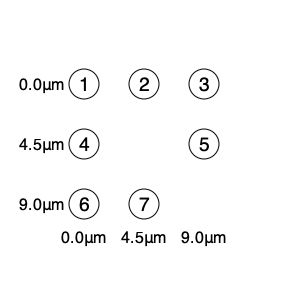

In [3]:
# Graph creation

Random.seed!(2)
atoms = generate_sites(SquareLattice(), 3, 3; scale = 4.5) |> random_dropout(0.2)


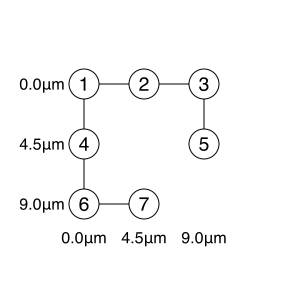

In [4]:
Bloqade.plot(atoms, blockade_radius = 4.5) # same radius

In [5]:
graph = BloqadeMIS.unit_disk_graph(atoms, 4.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 1.0)ₜ

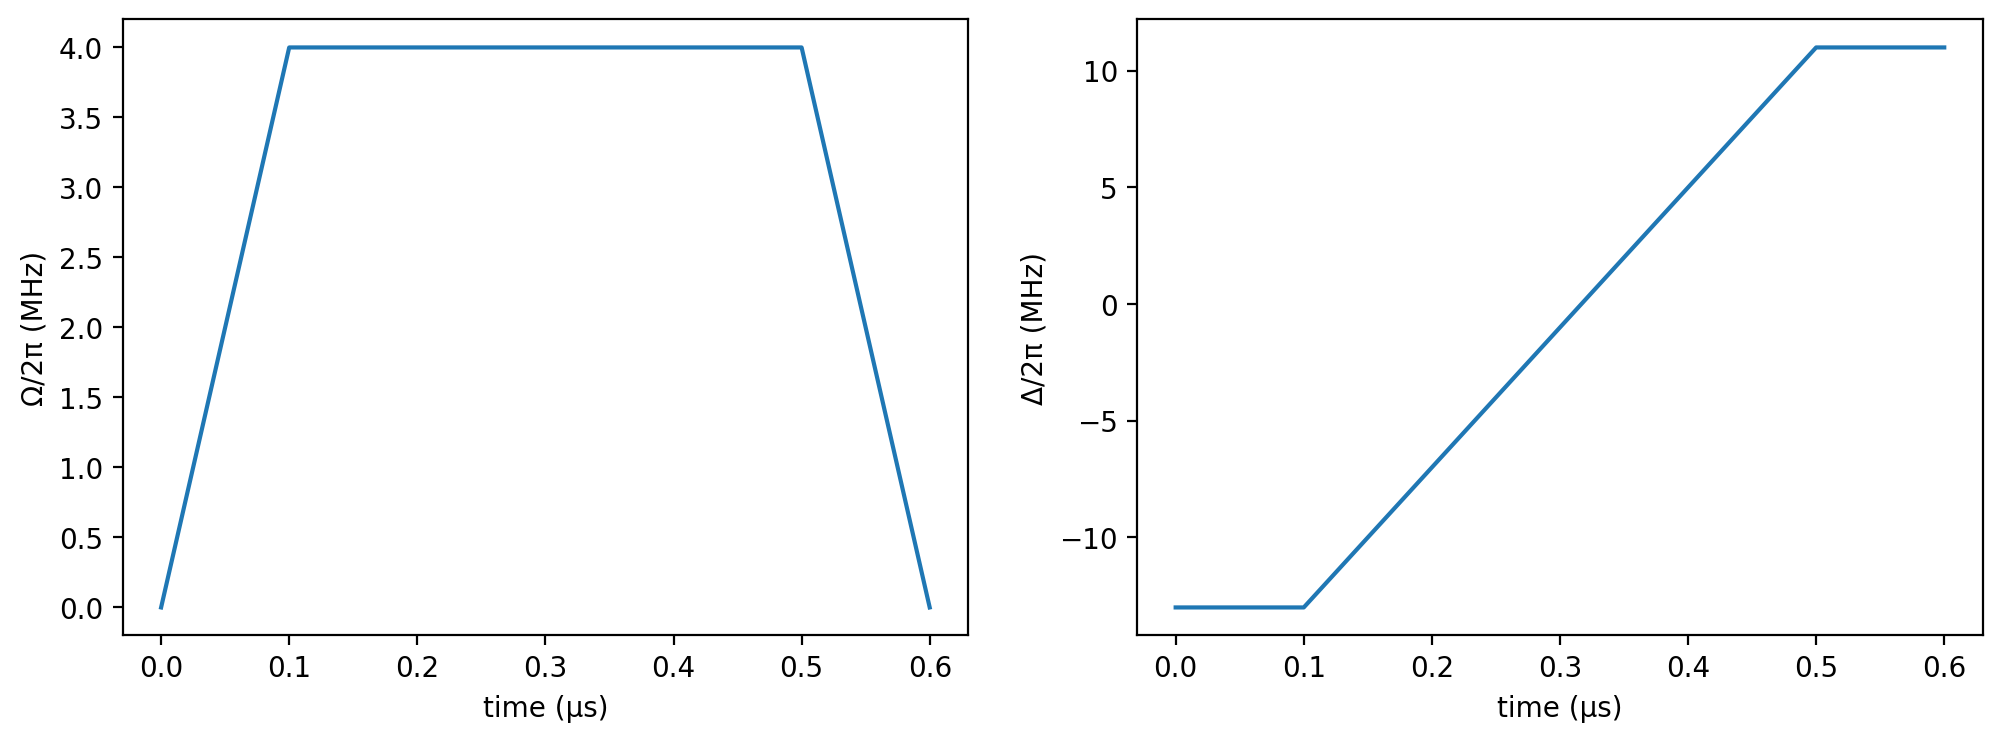

In [6]:
# adiabatic approach repeated

T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [7]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 15.023 KiB
    expression:
nqubits: 7
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


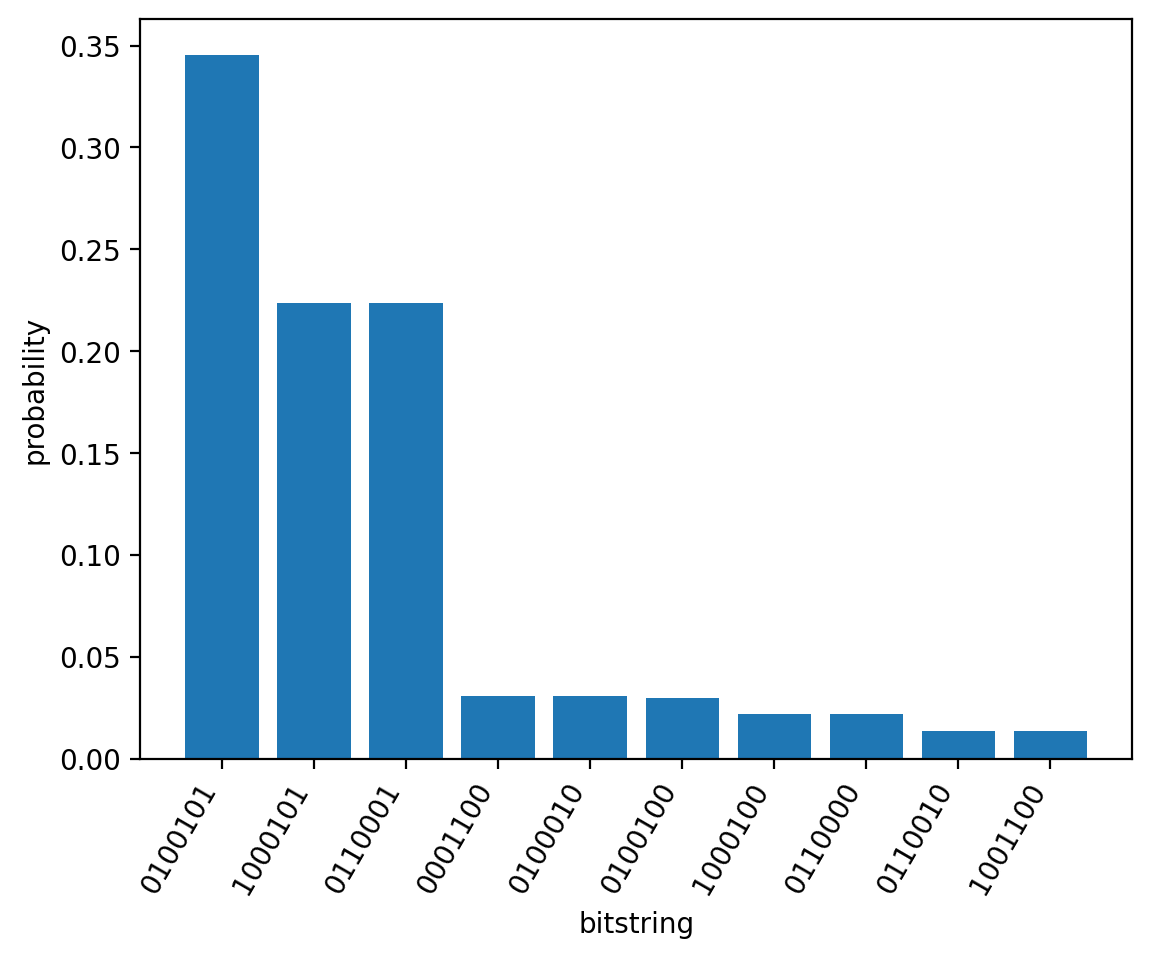

In [8]:
bitstring_hist(prob.reg; nlargest = 10)


In [14]:
# comparing with classical solution

best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

# visualize

Bloqade.plot(atoms, blockade_radius = 4.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

LoadError: AssertionError: all((bs->begin
            #= In[14]:5 =#
            GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c
        end), best_bit_strings)

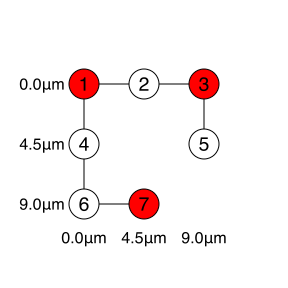

In [15]:
Bloqade.plot(atoms, blockade_radius = 4.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

In [11]:
best5_bit_strings = most_probable(prob.reg, 3)
BloqadeMIS.is_independent_set.(best5_bit_strings, Ref(graph))

3-element BitVector:
 1
 1
 1

In [12]:
fixed = mis_postprocessing(best5_bit_strings[3], graph)
BloqadeMIS.is_independent_set(fixed, graph)

true

In [16]:
# QAOA algorithm do later

import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 5]) # changed from 6 go back
G.add_edges_from([(0,1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 1), (1, 3), (1, 4)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

LoadError: ArgumentError: Package networkx not found in current path:
- Run `import Pkg; Pkg.add("networkx")` to install the networkx package.
